# Clustering of Countries

### Importing and Understanding Data

In [1]:
# Suppress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 100
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

In [3]:
# Identifying the encoding of the csv file to be used for this assignment

with open(r'C:\upGrad\Course 2\PCA_and_Clustering_Assignment\Country-data.csv') as f:
    print(f)

<_io.TextIOWrapper name='C:\\upGrad\\Course 2\\PCA_and_Clustering_Assignment\\Country-data.csv' mode='r' encoding='cp1252'>


In [4]:
# Importing Country-data.csv

path = r'C:\upGrad\Course 2\PCA_and_Clustering_Assignment'
country_df = pd.read_csv(path + '\\Country-data.csv')

In [5]:
# Looking at the first five rows

country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


##### Checking for Duplicate IDs

In [6]:
# Making sure that number of duplicate rows are zero

sum(country_df.duplicated(subset = 'country')) == 0

True

##### Primary Checks

In [7]:
# Determining the number of rows and columns in country_df

country_df.shape

(167, 10)

In [8]:
# Inspecting country_df

country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [9]:
# Getting statistical information for the numerical features of country_df

country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Cleaning the Data
###### Since `exports`, `health` and `imports` are percentages of the Total GDP, these will be converted accordingly to reflect the appropriate values

In [10]:
# Since 'gdpp' is the Per Capita GDP (GDP per person) and 'income' is the Net Income per Person, it stands to reason that 
# the 'exports', 'health' and 'imports' values should reflect the same i.e. per person. Hence, the conversion is done
# using percentage of 'gdpp'

country_df['exports'] = (country_df['exports'] / 100) * country_df['gdpp']
country_df['health'] = (country_df['health'] / 100) * country_df['gdpp']
country_df['imports'] = (country_df['imports'] / 100) * country_df['gdpp']

In [11]:
# Changing the data types for 'income' and 'gdpp'

country_df[['income', 'gdpp']] = country_df[['income', 'gdpp']].astype('float64')
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null float64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null float64
dtypes: float64(9), object(1)
memory usage: 13.1+ KB


In [12]:
# Reviewing statistical information for the numerical features of country_df

country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Visualising Numeric Variables

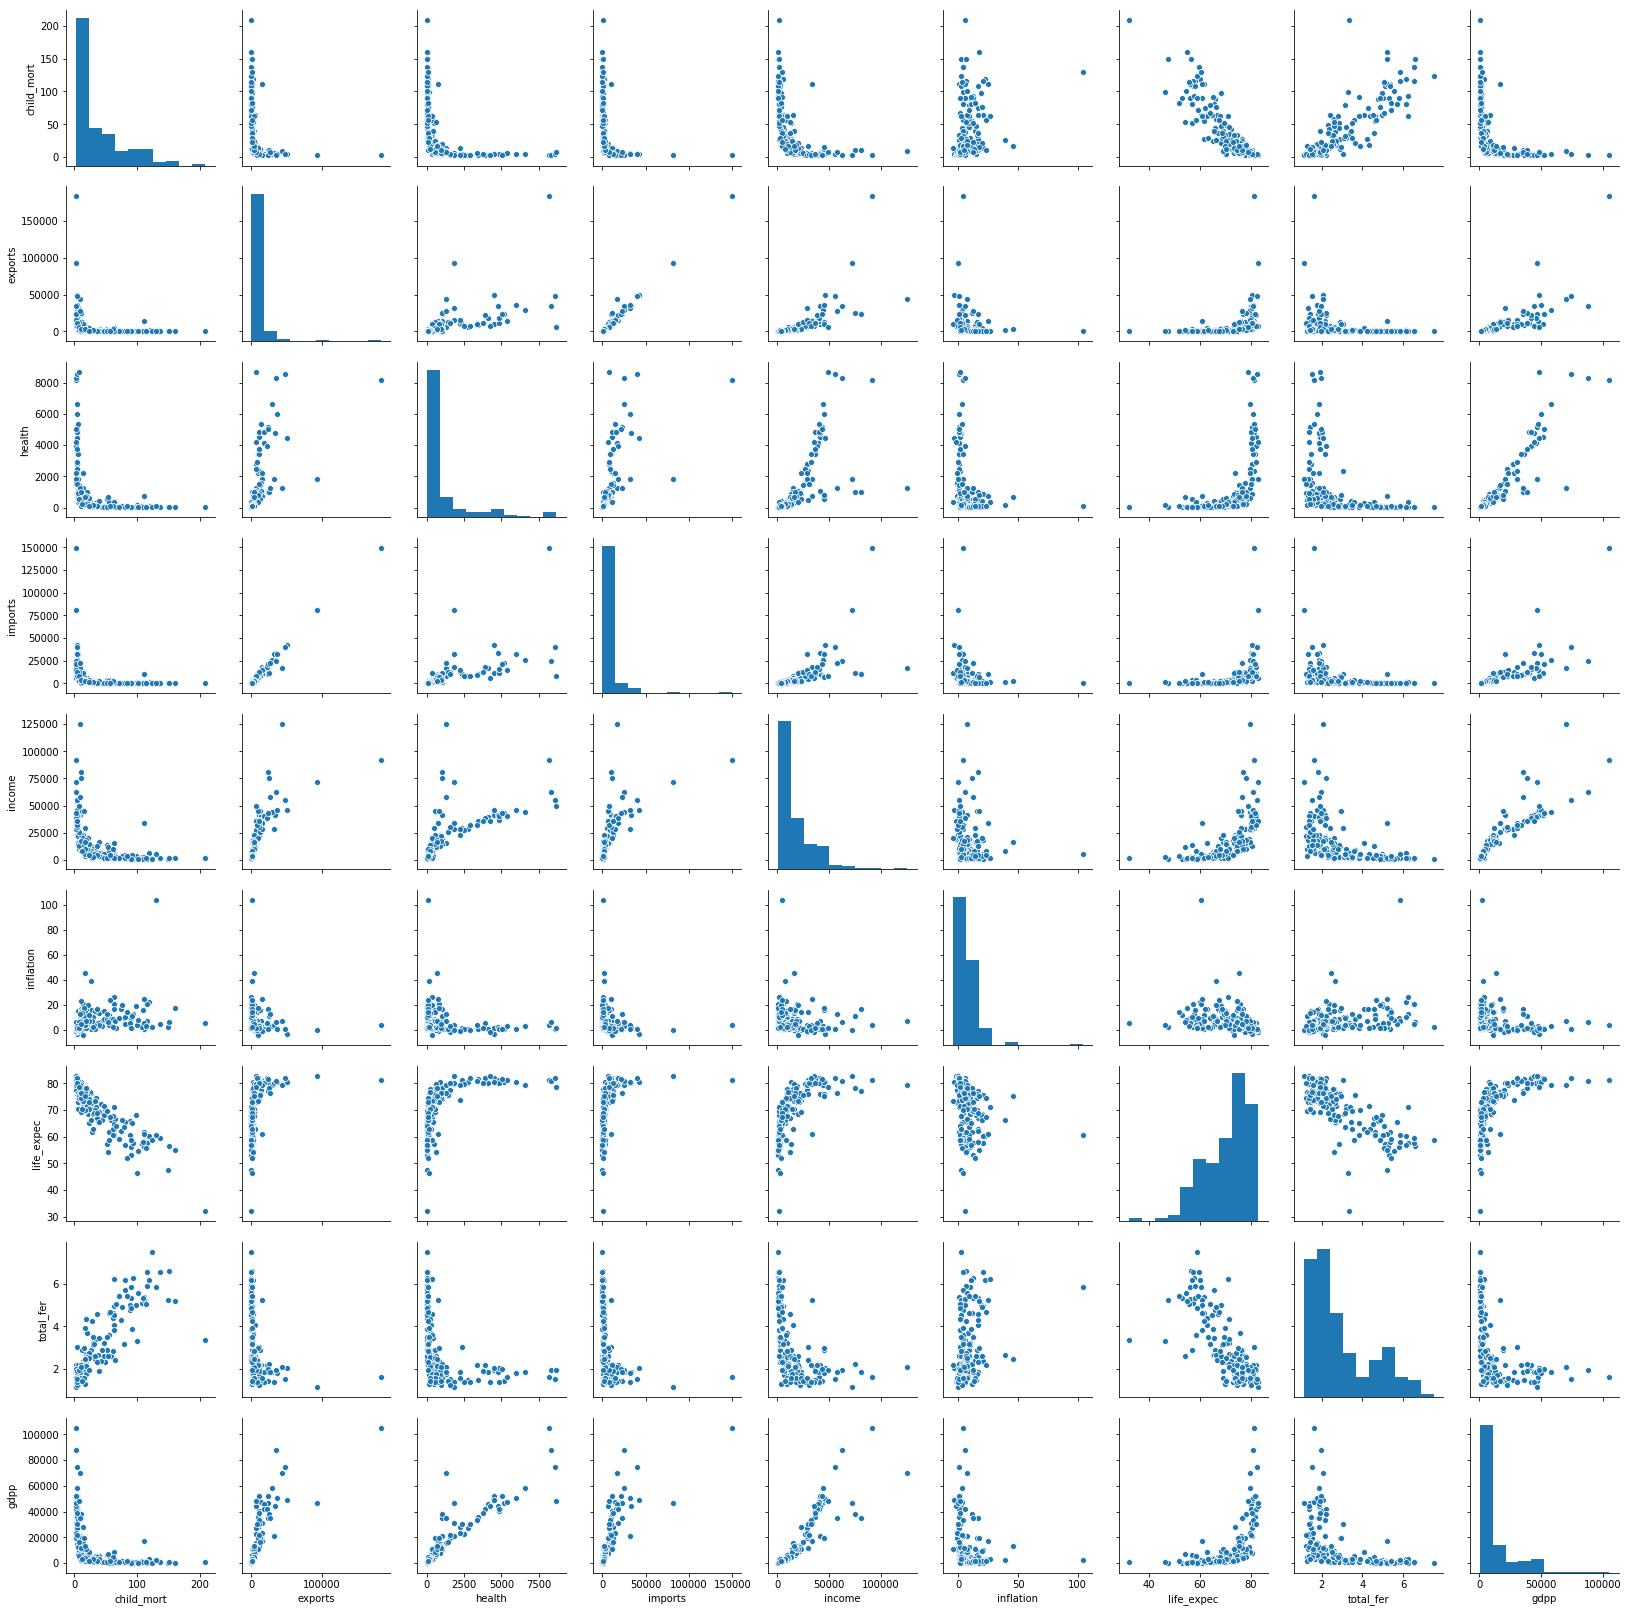

In [13]:
# Making a pairplot of all the numeric variables

sns.pairplot(country_df)
plt.show()

In [14]:
# Checking correlation in country_df for the numeric variables

country_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1,-0.3,-0.43,-0.32,-0.52,0.29,-0.89,0.85,-0.48
exports,-0.3,1,0.61,0.99,0.73,-0.14,0.38,-0.29,0.77
health,-0.43,0.61,1,0.64,0.69,-0.25,0.55,-0.41,0.92
imports,-0.32,0.99,0.64,1,0.67,-0.18,0.4,-0.32,0.76
income,-0.52,0.73,0.69,0.67,1,-0.15,0.61,-0.5,0.9
inflation,0.29,-0.14,-0.25,-0.18,-0.15,1,-0.24,0.32,-0.22
life_expec,-0.89,0.38,0.55,0.4,0.61,-0.24,1,-0.76,0.6
total_fer,0.85,-0.29,-0.41,-0.32,-0.5,0.32,-0.76,1,-0.45
gdpp,-0.48,0.77,0.92,0.76,0.9,-0.22,0.6,-0.45,1


### Deriving the datasets for model building

In [15]:
# Creating a list of column names for the numerical variables

num_vars = country_df.select_dtypes(exclude='object').columns

print(num_vars)

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')


In [16]:
# Assigning numerical variables to X
X = country_df[num_vars]

In [17]:
# Saving the 'country' column in a variable, so that I can make use of it later after performing PCA

country = country_df['country']

### Rescaling the features
- ##### Standard Scaling

In [18]:
# Creating a scaler object using StandardScaler()

scaler = StandardScaler()

In [19]:
# Applying scaler to all the columns of X

X_scaled = scaler.fit_transform(X)

In [20]:
X_scaled.shape

(167, 9)

## PCA

In [21]:
pca = PCA(random_state=42)

In [22]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

#### Components from the PCA

In [23]:
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

###### Looking at the explained variance ratio for each component

In [24]:
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

###### Making a scree plot for the cumulative variance ratio

In [25]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)
var_cumu

array([0.58937298, 0.77382467, 0.87293939, 0.93366217, 0.96395389,
       0.98855216, 0.9979496 , 0.99950602, 1.        ])

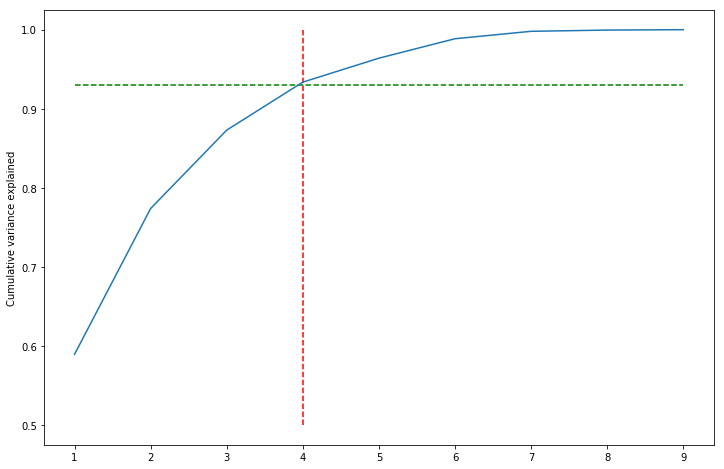

In [26]:
plt.figure(figsize=[12,8])
plt.vlines(x=4, ymax=1, ymin=0.5, colors="r", linestyles="--")
plt.hlines(y=0.93, xmax=9, xmin=1, colors="g", linestyles="--")
plt.plot(range(1, len(var_cumu)+1), var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

#### PCA with 4 Components

In [27]:
pca_final = PCA(n_components=4, random_state=42)

In [28]:
# Scaling and transforming the data to get Principal Components

Xscaled_pca = pca_final.fit_transform(X_scaled)

In [29]:
Xscaled_pca.shape

(167, 4)

###### Creating  and plotting a correlation matrix for the principal components

In [30]:
# Creating a transpose so that the each column is properly arranged

pc = np.transpose(Xscaled_pca)

In [31]:
corrmat = np.corrcoef(pc)

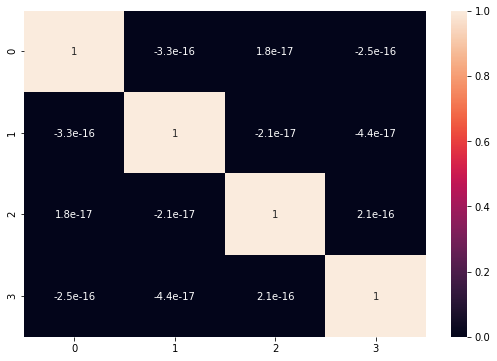

In [32]:
plt.figure(figsize = (9,6))
sns.heatmap(corrmat,annot = True)
plt.show()

<font color = purple> *It's clear from the correlation matrix above that none of the four variables are correlated with each other.* </font>

In [33]:
# Converting the 'pc' array to a dataframe

pca_df = pd.DataFrame({'PC1': pc[0], 'PC2': pc[1], 'PC3': pc[2], 'PC4': pc[3]})
pca_df.head()

,PC1,PC2,PC3,PC4
0,-2.635575,1.472267,-0.549489,-0.242326
1,-0.024206,-1.429892,-0.014123,0.450645
2,-0.459557,-0.675495,0.959355,0.218456
3,-2.722630,2.172332,0.600215,-0.433978
4,0.648597,-1.023437,-0.257430,0.289201


In [34]:
# Adding back 'country' to the dataframe of principal components

pca_df = pd.DataFrame({'country': list(country), 'PC1': pc[0], 'PC2': pc[1], 'PC3': pc[2], 'PC4': pc[3]})
pca_df.head()

,country,PC1,PC2,PC3,PC4
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326
1,Albania,-0.024206,-1.429892,-0.014123,0.450645
2,Algeria,-0.459557,-0.675495,0.959355,0.218456
3,Angola,-2.722630,2.172332,0.600215,-0.433978
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201


### Outlier Detection and Treatment

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6d74bf908>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6d74bff98>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6d74bf4a8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c6d736e668>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c6d736e9b0>],
 'means': []}

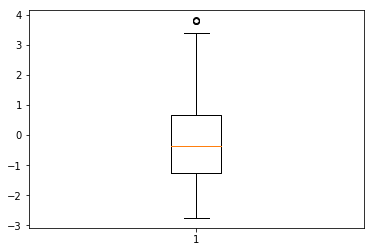

In [35]:
# Outlier analysis for PC1

Q1 = pca_df.PC1.quantile(0.05)
Q3 = pca_df.PC1.quantile(0.95)
IQR = Q3-Q1
pca_df = pca_df[(pca_df.PC1 >= Q1) & (pca_df.PC1 <= Q3)]
plt.boxplot(pca_df.PC1)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6d73c1a58>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6d73c1e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6d73c1630>],
 'medians': [<matplotlib.lines.Line2D at 0x1c6d73c97b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c6d73c9b00>],
 'means': []}

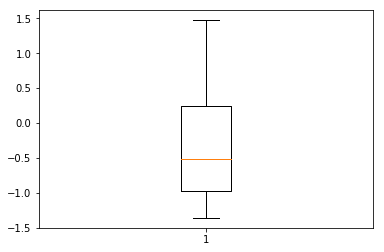

In [36]:
# Outlier analysis for PC2

Q1 = pca_df.PC2.quantile(0.05)
Q3 = pca_df.PC2.quantile(0.95)
IQR = Q3-Q1
pca_df = pca_df[(pca_df.PC2 >= Q1) & (pca_df.PC2 <= Q3)]
plt.boxplot(pca_df.PC2)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6d741f710>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6d741fda0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6d741f2e8>],
 'medians': [<matplotlib.lines.Line2D at 0x1c6d7429470>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c6d74297b8>],
 'means': []}

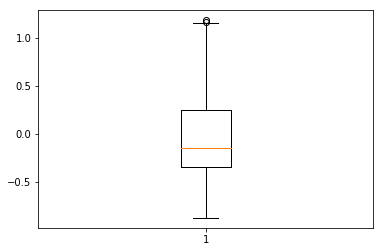

In [37]:
# Outlier analysis for PC3

Q1 = pca_df.PC3.quantile(0.05)
Q3 = pca_df.PC3.quantile(0.95)
IQR = Q3-Q1
pca_df = pca_df[(pca_df.PC3 >= Q1) & (pca_df.PC3 <= Q3)]
plt.boxplot(pca_df.PC3)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c6d7a82748>,
 'caps': [<matplotlib.lines.Line2D at 0x1c6d7a82dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c6d7a82320>],
 'medians': [<matplotlib.lines.Line2D at 0x1c6d7a8c4a8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c6d7a8c7f0>],
 'means': []}

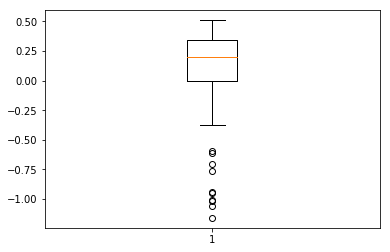

In [38]:
# Outlier analysis for PC4

Q1 = pca_df.PC4.quantile(0.05)
Q3 = pca_df.PC4.quantile(0.95)
IQR = Q3-Q1
pca_df = pca_df[(pca_df.PC4 >= Q1) & (pca_df.PC4 <= Q3)]
plt.boxplot(pca_df.PC4)

#### Reviewing the PCs after treating outliers

In [39]:
pca_df.head()

,country,PC1,PC2,PC3,PC4
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326
2,Algeria,-0.459557,-0.675495,0.959355,0.218456
4,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201
6,Armenia,-0.334555,-1.271889,0.190564,0.500247
8,Austria,3.816857,0.248363,-0.258960,-1.018163


In [40]:
pca_df.shape

(107, 5)

## K-means Clustering

### Hopkins Statistic

In [41]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [42]:
# Using the Hopkins Statistic function by passing the above dataframe as a paramter

hopkins(pca_df.drop('country', axis=1))

0.807799468303508

### Modelling

In [43]:
# Dropping the 'country' column in order to proceed with clustering

pca_cluster = pca_df.drop('country', axis=1)

In [44]:
# Inspecting shape of data

pca_cluster.shape

(107, 4)

In [45]:
# K-means with some arbitrary k

kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(pca_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [46]:
kmeans.labels_

array([2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1,
       2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 2, 2,
       1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 2])

#### Finding the Optimal Number of Clusters
#### SSD 

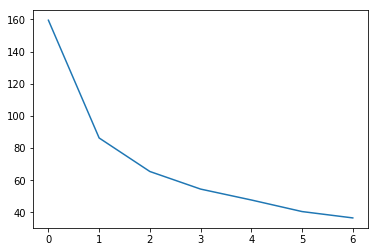

In [47]:
# Elbow-Curve / SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(pca_cluster)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

#### Silhouette Analysis

In [48]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # initialize kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=42)
    kmeans.fit(pca_cluster)
    
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(pca_cluster, cluster_labels)
    print('For n_clusters={0}, the silhouette score is {1}'.format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4261940596375071
For n_clusters=3, the silhouette score is 0.4403225974253727
For n_clusters=4, the silhouette score is 0.36724936472605324
For n_clusters=5, the silhouette score is 0.34798185948341764
For n_clusters=6, the silhouette score is 0.3286279474852987
For n_clusters=7, the silhouette score is 0.35903849609349087
For n_clusters=8, the silhouette score is 0.3231798899083617


<font color = purple> *Based on both the elbow curve as well as the silhouette scores, I elected to proceed with 3 clusters for the K-Means algorithm.* </font>

#### Final model with `k = 3`

In [49]:
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=42)
kmeans.fit(pca_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [50]:
kmeans.labels_

array([2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 0, 1,
       2, 0, 0, 2, 1, 1, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 2, 2,
       1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 2])

In [51]:
# Adding the cluster IDs to the PCs data 

pca_km = pd.concat([pca_df.reset_index().drop('index', axis=1), pd.Series(kmeans.labels_)], axis=1)
pca_km.columns = ['country', 'PC1', 'PC2', 'PC3', 'PC4', 'KM_ClusterID']
pca_km.head()

,country,PC1,PC2,PC3,PC4,KM_ClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,2
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,0
4,Austria,3.816857,0.248363,-0.258960,-1.018163,1


In [52]:
# Checking the count of observations per cluster

pca_km.KM_ClusterID.value_counts()

0    55
2    31
1    21
Name: KM_ClusterID, dtype: int64

###### Inspecting the new dataframe `pca_km` w.r.t the `ClusterID` values

In [53]:
pca_km[pca_km['KM_ClusterID']==0]

,country,PC1,PC2,PC3,PC4,KM_ClusterID
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,0
5,Azerbaijan,-0.467995,-0.492682,0.609900,0.254612,0
8,Bangladesh,-1.015167,-0.708743,-0.101817,0.368131,0
9,Barbados,0.844166,-1.007877,-0.410556,0.138432,0
10,Belize,-0.403885,-0.918070,-0.505679,0.381123,0
11,Bhutan,-0.716048,-0.765607,-0.125975,0.357155,0
12,Bolivia,-1.018777,-0.424926,0.054565,0.213645,0
14,Brazil,0.165170,-1.019495,0.282993,-0.026759,0


In [54]:
pca_km[pca_km['KM_ClusterID']==1]

,country,PC1,PC2,PC3,PC4,KM_ClusterID
4,Austria,3.816857,0.248363,-0.258960,-1.018163,1
6,Bahamas,1.498962,-0.429632,-0.544543,-0.250327,1
7,Bahrain,1.470888,-0.328925,0.397298,0.170862,1
24,Cyprus,2.313336,-0.552303,-0.068162,0.128753,1
25,Czech Republic,1.673993,-0.867533,-0.441891,0.256369,1
33,Finland,3.202413,-0.011928,-0.281535,-1.006409,1
37,Germany,3.300272,-0.171370,-0.241391,-1.159405,1
39,Greece,1.929999,-1.026436,-0.199776,-0.608653,1
43,Iceland,3.100654,0.158568,0.194322,-0.760189,1
48,Israel,1.782848,-0.404330,-0.151148,-0.592874,1


In [55]:
pca_km[pca_km['KM_ClusterID']==2]

,country,PC1,PC2,PC3,PC4,KM_ClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,2
13,Botswana,-1.129489,0.401611,-0.231994,0.102647,2
16,Cambodia,-1.179654,-0.488714,-0.570851,0.330359,2
21,Comoros,-1.949130,0.606917,-0.774798,-0.093182,2
22,"Congo, Rep.",-2.047343,1.089177,0.717277,-0.023571,2
30,Eritrea,-1.948339,0.496371,-0.039610,0.052654,2
34,Gabon,-1.281841,0.850425,0.514767,-0.110677,2
35,Gambia,-2.104642,0.826788,-0.762354,-0.201412,2
38,Ghana,-2.001961,0.753168,0.373761,0.000606,2
44,India,-1.265440,-0.270128,-0.065633,0.276526,2


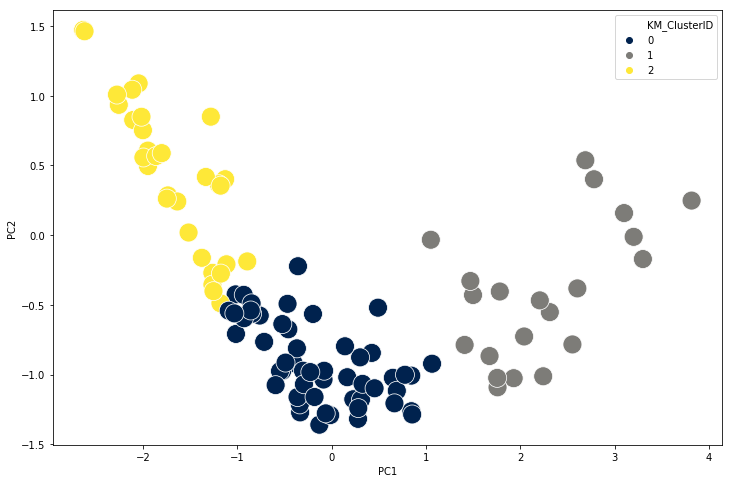

In [56]:
# Plot the first two principal components (PC1 and PC2) with respect to the clusters obtained

plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='KM_ClusterID', s=360, palette='cividis', legend='full', data=pca_km)
plt.show()

### Cluster Profiling

In [57]:
# Merging the original data with the pca (ClusterID) data

km_cluster_df = pd.merge(country_df, pca_km, how='inner', on='country')
km_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,KM_ClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,-2.635575,1.472267,-0.549489,-0.242326,2
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,-0.334555,-1.271889,0.190564,0.500247,0
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,3.816857,0.248363,-0.258960,-1.018163,1


In [58]:
# Removing PCs from the data

km_cluster_df.drop(['PC1', 'PC2', 'PC3', 'PC4'], axis=1, inplace=True)
km_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,KM_ClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,2
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,0
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,0
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,1


### Visualizations on the Clusters Formed
#### Scatterplots showing the `3` Clusters obtained using K-means

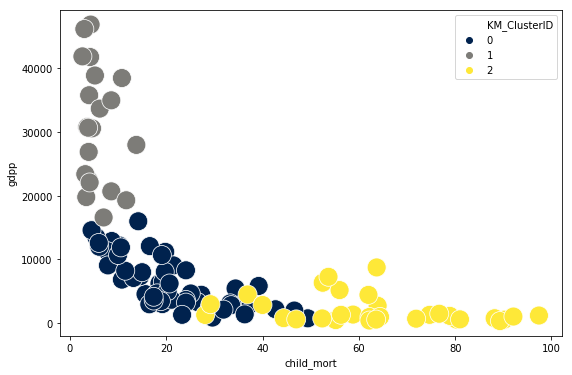

In [59]:
# Child Mortality Rate vs Per Capita GDP

plt.figure(figsize=(9,6))
sns.scatterplot(x='child_mort', y='gdpp', hue='KM_ClusterID', s=360, palette='cividis', data=km_cluster_df)
plt.show()

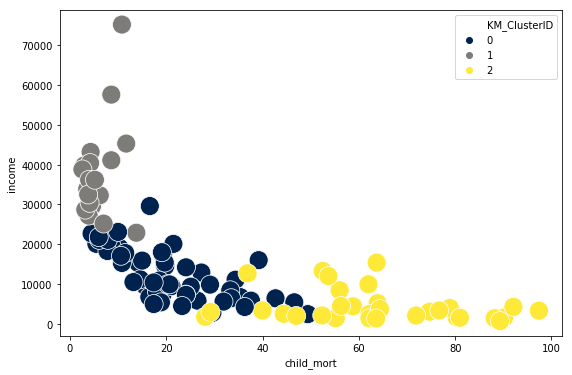

In [60]:
# Child Mortality Rate vs Net Income per Person

plt.figure(figsize=(9,6))
sns.scatterplot(x='child_mort', y='income', hue='KM_ClusterID', s=360, palette='cividis', data=km_cluster_df)
plt.show()

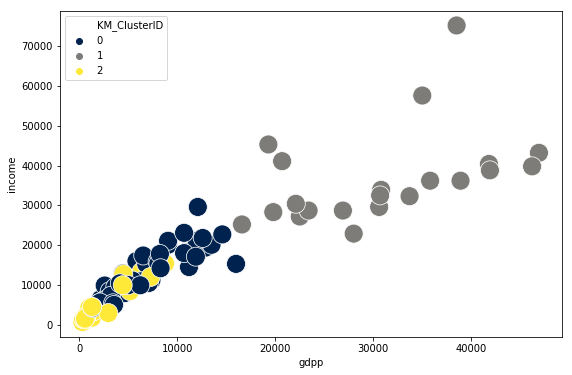

In [61]:
# Per Capita GDP vs Net Income per Person

plt.figure(figsize=(9,6))
sns.scatterplot(x='gdpp', y='income', hue='KM_ClusterID', s=360, palette='cividis', data=km_cluster_df)
plt.show()

In [62]:
km_cluster_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'KM_ClusterID'],
      dtype='object')

<font color = purple> *Now that I have performed K-means clustering using the PCs and have allocated the cluster IDs back to each of the datapoints, I can proceed with the cluster analysis.* </font>

### Cluster Analysis

#### Using box plots to visualize variables such as `child_mort`, `income` and `gdpp` against the clusters

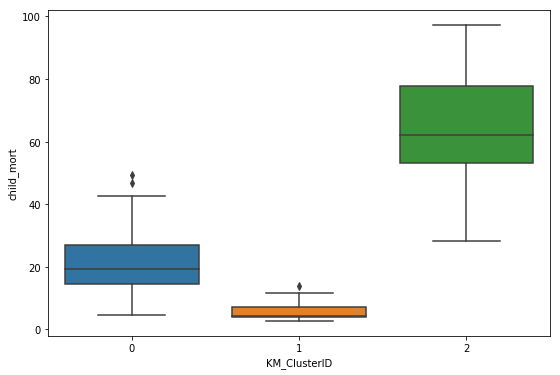

In [112]:
# Child Mortality Rate

plt.figure(figsize=(9,6))
sns.boxplot(x = 'KM_ClusterID', y = 'child_mort', data = km_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `2` clearly includes countries that have a significantly higher `Child Mortality Rate` compared to the countries in the remaining two clusters.* </font>

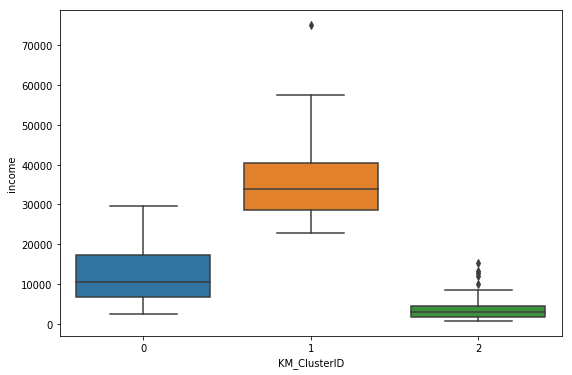

In [113]:
# Net Income per Person

plt.figure(figsize=(9,6))
sns.boxplot(x = 'KM_ClusterID', y = 'income', data = km_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `2` clearly includes countries that have a significantly lower `Net Income per Person` compared to the countries in the remaining two clusters.* </font>

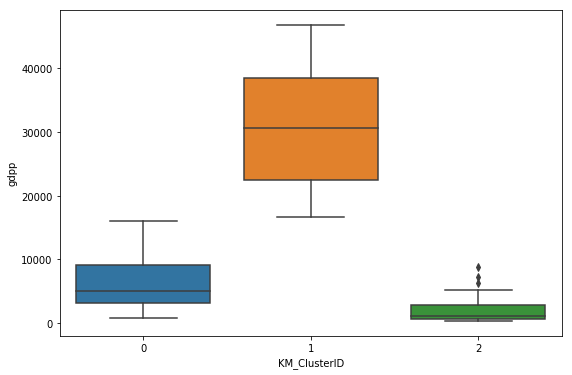

In [114]:
# Per Capita GDP

plt.figure(figsize=(9,6))
sns.boxplot(x = 'KM_ClusterID', y = 'gdpp', data = km_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `2` clearly includes countries that have a significantly lower `Per Capita GDP` compared to the countries in the remaining two clusters.* </font>

In [63]:
# Profiling the cluster by taking the mean of various attributes

child_mort = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).child_mort.mean())
exports = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).exports.mean())
health = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).health.mean())
imports = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).imports.mean())
income = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).income.mean())
inflation = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).inflation.mean())
life_expec = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).life_expec.mean())
total_fer = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).total_fer.mean())
gdpp = pd.DataFrame(km_cluster_df.groupby(['KM_ClusterID']).gdpp.mean())

In [64]:
# Combining the results with the Cluster ID columns

km_final_df = pd.concat([child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp], axis=1)
km_final_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
KM_ClusterID,,,,,,,,,
0,21.218182,2703.732000,403.734865,2844.823345,12084.727273,6.381291,73.294545,2.328909,6381.600000
1,5.738095,14300.409524,2562.558095,12960.300000,36833.333333,3.138190,79.147619,1.803810,30957.142857
2,63.651613,861.023623,128.778690,858.977519,4450.000000,9.736452,63.329032,4.111935,2072.161290


## Identifying Countries in Direst Need of Aid

In [65]:
# List of countries in dire need of aid obtained via K-means clustering

km_cluster_df[km_cluster_df['KM_ClusterID']==2]['country'].to_frame()

,country
0,Afghanistan
13,Botswana
16,Cambodia
21,Comoros
22,"Congo, Rep."
30,Eritrea
34,Gabon
35,Gambia
38,Ghana
44,India


## Hierarchical Clustering

In [66]:
pca_cluster.head()

,PC1,PC2,PC3,PC4
0,-2.635575,1.472267,-0.549489,-0.242326
2,-0.459557,-0.675495,0.959355,0.218456
4,0.648597,-1.023437,-0.257430,0.289201
6,-0.334555,-1.271889,0.190564,0.500247
8,3.816857,0.248363,-0.258960,-1.018163


### Single Linkage

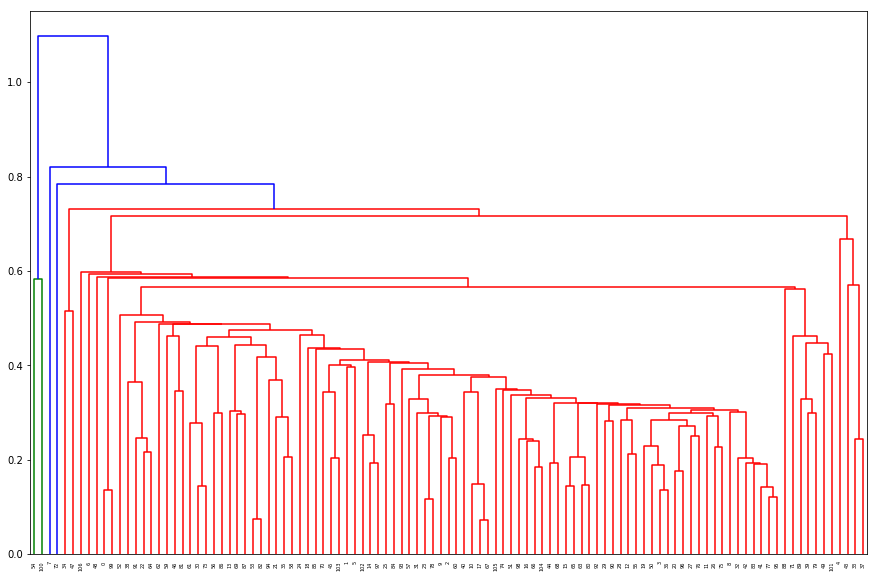

In [67]:
plt.figure(figsize=(15,10))
mergings = linkage(pca_cluster, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

#### Selecting 6 clusters

In [68]:
cluster_labels = cut_tree(mergings, n_clusters=6).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0])

In [69]:
# Adding the cluster IDs to the PCs data 

pca_single = pd.concat([pca_df.reset_index().drop('index', axis=1), pd.Series(cluster_labels)], axis=1)
pca_single.columns = ['country', 'PC1', 'PC2', 'PC3', 'PC4', 'SingleClusterID']
pca_single.head()

,country,PC1,PC2,PC3,PC4,SingleClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,0
4,Austria,3.816857,0.248363,-0.258960,-1.018163,1


###### Inspecting the dataframe `pca_single` w.r.t the `SingleClusterID` values

In [70]:
pca_single[pca_single['SingleClusterID']==0]

,country,PC1,PC2,PC3,PC4,SingleClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,0
5,Azerbaijan,-0.467995,-0.492682,0.609900,0.254612,0
6,Bahamas,1.498962,-0.429632,-0.544543,-0.250327,0
8,Bangladesh,-1.015167,-0.708743,-0.101817,0.368131,0
9,Barbados,0.844166,-1.007877,-0.410556,0.138432,0
10,Belize,-0.403885,-0.918070,-0.505679,0.381123,0
11,Bhutan,-0.716048,-0.765607,-0.125975,0.357155,0


In [71]:
pca_single[pca_single['SingleClusterID']==1]

,country,PC1,PC2,PC3,PC4,SingleClusterID
4,Austria,3.816857,0.248363,-0.258960,-1.018163,1
33,Finland,3.202413,-0.011928,-0.281535,-1.006409,1
37,Germany,3.300272,-0.171370,-0.241391,-1.159405,1
43,Iceland,3.100654,0.158568,0.194322,-0.760189,1


In [72]:
pca_single[pca_single['SingleClusterID']==2]

,country,PC1,PC2,PC3,PC4,SingleClusterID
7,Bahrain,1.470888,-0.328925,0.397298,0.170862,2


In [73]:
pca_single[pca_single['SingleClusterID']==3]

,country,PC1,PC2,PC3,PC4,SingleClusterID
34,Gabon,-1.281841,0.850425,0.514767,-0.110677,3
47,Iraq,-1.197990,0.365722,0.665672,-0.092386,3


In [74]:
pca_single[pca_single['SingleClusterID']==4]

,country,PC1,PC2,PC3,PC4,SingleClusterID
54,Kuwait,2.781989,0.401239,1.018050,-0.156166,4
100,United Arab Emirates,2.690125,0.537469,0.921754,0.395069,4


In [75]:
pca_single[pca_single['SingleClusterID']==5]

,country,PC1,PC2,PC3,PC4,SingleClusterID
72,Oman,1.051429,-0.032822,1.151639,0.083401,5


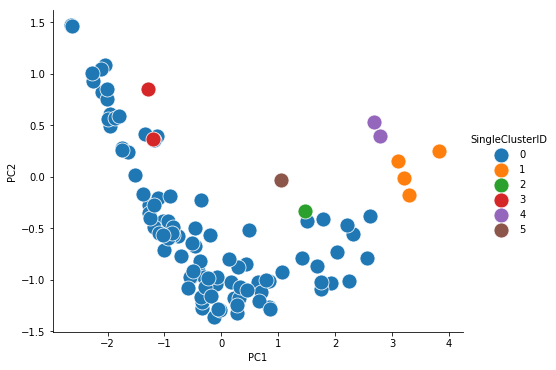

In [76]:
# Plot the Cluster with respect to the clusters obtained

sns.pairplot(x_vars='PC1', y_vars='PC2', kind='scatter', hue='SingleClusterID', 
             height=5.25, aspect=1.25, plot_kws={'s': 225}, data=pca_single)
plt.show()

### Cluster Profiling

In [77]:
# Merging the original data with the pca (SingleClusterID) data

hs_cluster_df = pd.merge(country_df, pca_single, how='inner', on='country')
hs_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,SingleClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,-2.635575,1.472267,-0.549489,-0.242326,0
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,-0.459557,-0.675495,0.959355,0.218456,0
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0.648597,-1.023437,-0.257430,0.289201,0
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,-0.334555,-1.271889,0.190564,0.500247,0
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,3.816857,0.248363,-0.258960,-1.018163,1


In [78]:
# Removing PCs from the data

hs_cluster_df.drop(['PC1', 'PC2', 'PC3', 'PC4'], axis=1, inplace=True)
hs_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,SingleClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,0
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,0
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,1


### Visualizations on the Clusters Formed
#### Scatterplots showing the `6` Clusters obtained using Hierarchical clustering via Single Linkage

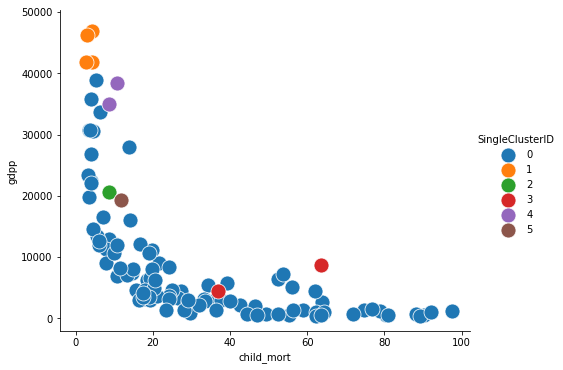

In [79]:
# Child Mortality Rate vs Per Capita GDP

sns.pairplot(x_vars='child_mort', y_vars='gdpp', kind='scatter', hue='SingleClusterID', 
             height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hs_cluster_df)
plt.show()

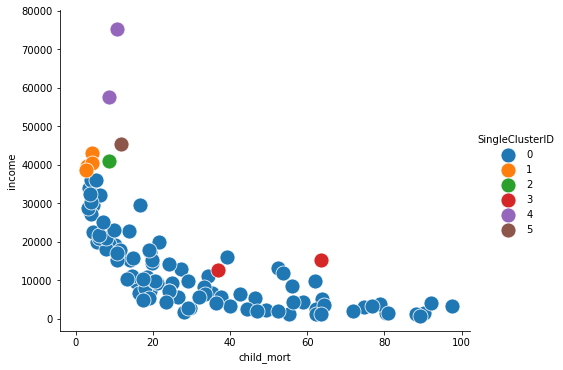

In [80]:
# Child Mortality Rate vs Net Income per Person

sns.pairplot(x_vars='child_mort', y_vars='income', kind='scatter', hue='SingleClusterID', 
             height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hs_cluster_df)
plt.show()

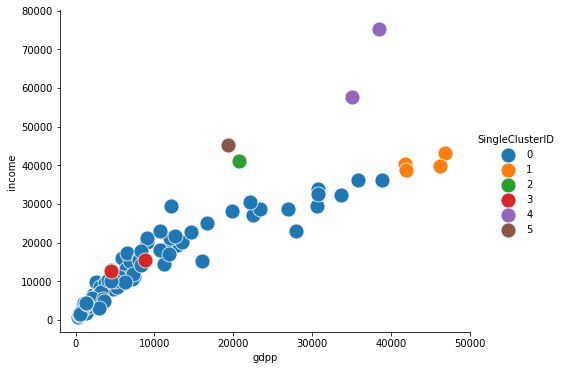

In [81]:
# Per Capita GDP vs Net Income per Person

sns.pairplot(x_vars='gdpp', y_vars='income', kind='scatter', hue='SingleClusterID', 
             height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hs_cluster_df)
plt.show()

In [82]:
hs_cluster_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'SingleClusterID'],
      dtype='object')

<font color = purple> *Now that I have performed Hierarchical clustering with Single Linkage using the PCs and have allocated the cluster IDs back to each of the datapoints, I can proceed with the cluster analysis.* </font>

### Cluster Analysis

#### Using box plots to visualize variables such as `child_mort`, `income` and `gdpp` against the clusters

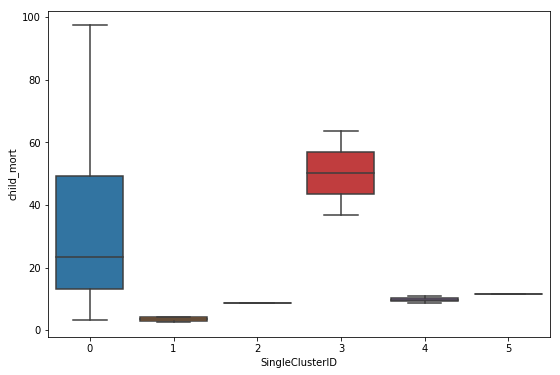

In [115]:
# Child Mortality Rate

plt.figure(figsize=(9,6))
sns.boxplot(x = 'SingleClusterID', y = 'child_mort', data = hs_cluster_df)
plt.show()

###### Checking range of values for `Child Mortality Rate` in cluster label `0`

In [119]:
hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['child_mort'].max(), hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['child_mort'].min() 

(97.4, 3.2)

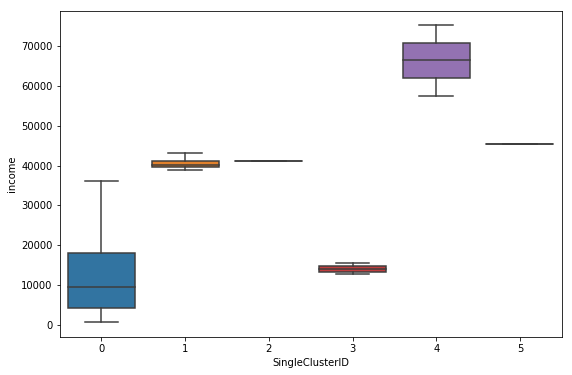

In [116]:
# Net Income per Person

plt.figure(figsize=(9,6))
sns.boxplot(x = 'SingleClusterID', y = 'income', data = hs_cluster_df)
plt.show()

###### Checking range of values for `Net Income per Person` in cluster label `0`

In [120]:
hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['income'].max(), hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['income'].min() 

(36200.0, 700.0)

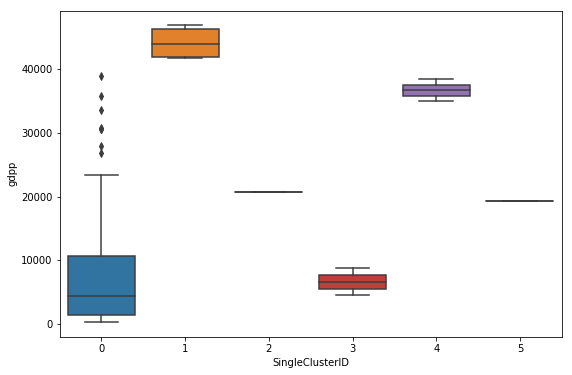

In [117]:
# Per Capita GDP

plt.figure(figsize=(9,6))
sns.boxplot(x = 'SingleClusterID', y = 'gdpp', data = hs_cluster_df)
plt.show()

###### Checking range of values for `Per Capita GDP` in cluster label `0`

In [121]:
hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['gdpp'].max(), hs_cluster_df[hs_cluster_df['SingleClusterID']==0]['gdpp'].min() 

(38900.0, 327.0)

<font color = purple> *As we can see from the box plots as well as the single linkage dendrogram above, even if we selected a higher number of clusters, there would be several clusters with a single country each. Moreover, the majority of countries are in the first cluster across a broad range for variables such as `gdpp`, `child_mort` and `income`.* </font>

<font color = purple> *Since this is far from an ideal outcome, I will move onto hierarchical clustering using complete linkage.* </font>

In [83]:
# Profiling the cluster by taking the mean of various attributes

child_mort = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).child_mort.mean())
exports = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).exports.mean())
health = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).health.mean())
imports = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).imports.mean())
income = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).income.mean())
inflation = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).inflation.mean())
life_expec = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).life_expec.mean())
total_fer = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).total_fer.mean())
gdpp = pd.DataFrame(hs_cluster_df.groupby(['SingleClusterID']).gdpp.mean())

In [84]:
# Combining the results with the Cluster ID columns

hs_final_df = pd.concat([child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp], axis=1)
hs_final_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
SingleClusterID,,,,,,,,,
0,32.023711,3164.408684,591.632237,3363.63131,12026.907216,6.508361,71.103093,2.770722,7853.350515
1,3.525000,20498.775000,4520.325000,18336.87500,40550.000000,1.863000,80.650000,1.725000,44200.000000
2,8.600000,14386.500000,1028.790000,10536.30000,41100.000000,7.440000,76.000000,2.160000,20700.000000
3,50.300000,3410.875000,342.350000,1594.12500,14050.000000,16.600000,65.050000,4.320000,6625.000000
4,9.700000,26437.250000,1146.775000,16982.00000,66400.000000,11.850000,77.350000,2.040000,36750.000000
5,11.700000,12680.100000,534.610000,7951.60000,45300.000000,15.600000,76.100000,2.900000,19300.000000


## Identifying Countries in Direst Need of Aid

In [85]:
# List of countries in dire need of aid obtained via Hierarchical clustering with Single Linkage

hs_cluster_df[hs_cluster_df['SingleClusterID']==3]['country'].to_frame()

,country
34,Gabon
47,Iraq


### Complete Linkage

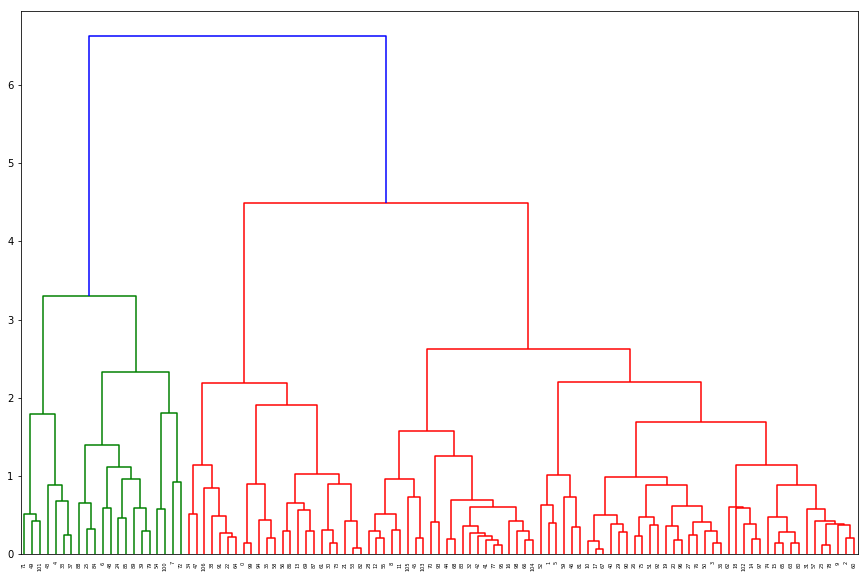

In [86]:
plt.figure(figsize=(15,10))
mergings = linkage(pca_cluster, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

#### Selecting 3 clusters

In [87]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 2, 0, 2, 1, 1, 1, 2,
       1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 0, 0,
       2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0])

In [88]:
# Adding the cluster IDs to the PCs data 

pca_complete = pd.concat([pca_df.reset_index().drop('index', axis=1), pd.Series(cluster_labels)], axis=1)
pca_complete.columns = ['country', 'PC1', 'PC2', 'PC3', 'PC4', 'CompleteClusterID']
pca_complete.head()

,country,PC1,PC2,PC3,PC4,CompleteClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,1
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,1
4,Austria,3.816857,0.248363,-0.258960,-1.018163,2


###### Inspecting the dataframe `pca_complete` w.r.t the `CompleteClusterID` values

In [89]:
pca_complete[pca_complete['CompleteClusterID']==0]

,country,PC1,PC2,PC3,PC4,CompleteClusterID
0,Afghanistan,-2.635575,1.472267,-0.549489,-0.242326,0
13,Botswana,-1.129489,0.401611,-0.231994,0.102647,0
21,Comoros,-1.949130,0.606917,-0.774798,-0.093182,0
22,"Congo, Rep.",-2.047343,1.089177,0.717277,-0.023571,0
30,Eritrea,-1.948339,0.496371,-0.039610,0.052654,0
34,Gabon,-1.281841,0.850425,0.514767,-0.110677,0
35,Gambia,-2.104642,0.826788,-0.762354,-0.201412,0
38,Ghana,-2.001961,0.753168,0.373761,0.000606,0
47,Iraq,-1.197990,0.365722,0.665672,-0.092386,0
53,Kenya,-1.736918,0.285212,-0.879188,0.047357,0


In [90]:
pca_complete[pca_complete['CompleteClusterID']==1]

,country,PC1,PC2,PC3,PC4,CompleteClusterID
1,Algeria,-0.459557,-0.675495,0.959355,0.218456,1
2,Antigua and Barbuda,0.648597,-1.023437,-0.257430,0.289201,1
3,Armenia,-0.334555,-1.271889,0.190564,0.500247,1
5,Azerbaijan,-0.467995,-0.492682,0.609900,0.254612,1
8,Bangladesh,-1.015167,-0.708743,-0.101817,0.368131,1
9,Barbados,0.844166,-1.007877,-0.410556,0.138432,1
10,Belize,-0.403885,-0.918070,-0.505679,0.381123,1
11,Bhutan,-0.716048,-0.765607,-0.125975,0.357155,1
12,Bolivia,-1.018777,-0.424926,0.054565,0.213645,1
14,Brazil,0.165170,-1.019495,0.282993,-0.026759,1


In [91]:
pca_complete[pca_complete['CompleteClusterID']==2]

,country,PC1,PC2,PC3,PC4,CompleteClusterID
4,Austria,3.816857,0.248363,-0.258960,-1.018163,2
6,Bahamas,1.498962,-0.429632,-0.544543,-0.250327,2
7,Bahrain,1.470888,-0.328925,0.397298,0.170862,2
24,Cyprus,2.313336,-0.552303,-0.068162,0.128753,2
25,Czech Republic,1.673993,-0.867533,-0.441891,0.256369,2
33,Finland,3.202413,-0.011928,-0.281535,-1.006409,2
37,Germany,3.300272,-0.171370,-0.241391,-1.159405,2
39,Greece,1.929999,-1.026436,-0.199776,-0.608653,2
43,Iceland,3.100654,0.158568,0.194322,-0.760189,2
48,Israel,1.782848,-0.404330,-0.151148,-0.592874,2


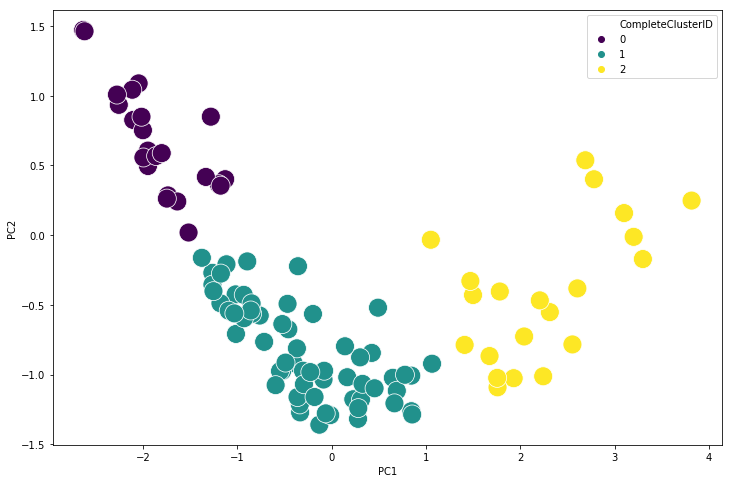

In [92]:
# Plot the Cluster with respect to the clusters obtained

# sns.pairplot(x_vars='PC1', y_vars='PC2', kind='scatter', hue='CompleteClusterID', 
#              height=6.25, aspect=1.25, plot_kws={'s': 200}, data=pca_complete)
# plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='CompleteClusterID', s=360, palette='viridis', data=pca_complete)
plt.show()

### Cluster Profiling

In [93]:
# Merging the original data with the pca (CompleteClusterID) data

hc_cluster_df = pd.merge(country_df, pca_complete, how='inner', on='country')
hc_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,CompleteClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,-2.635575,1.472267,-0.549489,-0.242326,0
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,-0.459557,-0.675495,0.959355,0.218456,1
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0.648597,-1.023437,-0.257430,0.289201,1
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,-0.334555,-1.271889,0.190564,0.500247,1
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,3.816857,0.248363,-0.258960,-1.018163,2


In [94]:
# Removing PCs from the data

hc_cluster_df.drop(['PC1', 'PC2', 'PC3', 'PC4'], axis=1, inplace=True)
hc_cluster_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,CompleteClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
1,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,1
2,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,1
3,Armenia,18.1,669.76,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,1
4,Austria,4.3,24059.70,5159.0000,22418.200,43200.0,0.873,80.5,1.44,46900.0,2


### Visualizations on the Clusters Formed
#### Scatterplots showing the `3` Clusters obtained using K-means

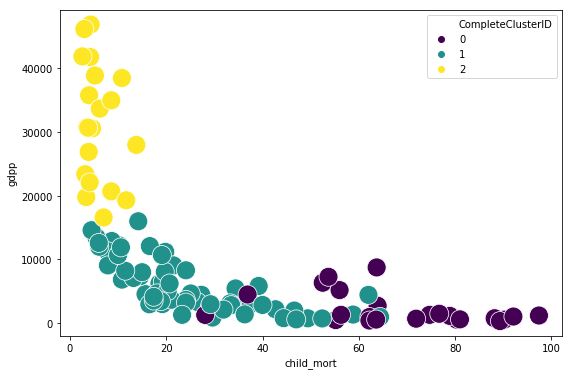

In [95]:
# Child Mortality Rate vs Per Capita GDP

# sns.pairplot(x_vars='child_mort', y_vars='gdpp', kind='scatter', hue='CompleteClusterID', 
#              height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hc_cluster_df)

plt.figure(figsize=(9,6))
sns.scatterplot(x='child_mort', y='gdpp', hue='CompleteClusterID', s=360, palette='viridis', data=hc_cluster_df)
plt.show()

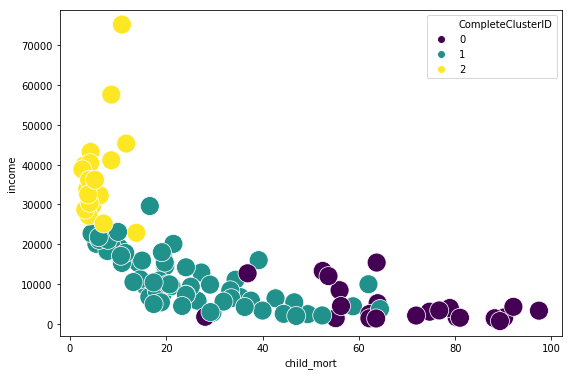

In [96]:
# Child Mortality Rate vs Net Income per Person

# sns.pairplot(x_vars='child_mort', y_vars='income', kind='scatter', hue='CompleteClusterID', 
#              height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hc_cluster_df)

plt.figure(figsize=(9,6))
sns.scatterplot(x='child_mort', y='income', hue='CompleteClusterID', s=360, palette='viridis', data=hc_cluster_df)
plt.show()

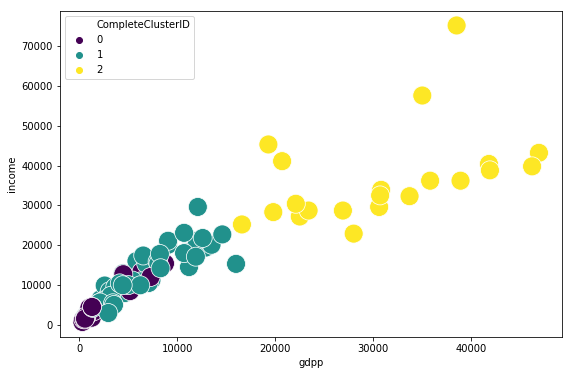

In [97]:
# Per Capita GDP vs Net Income per Person

# sns.pairplot(x_vars='gdpp', y_vars='income', kind='scatter', hue='CompleteClusterID', 
#              height=5.25, aspect=1.25, plot_kws={'s': 225}, data=hc_cluster_df)

plt.figure(figsize=(9,6))
sns.scatterplot(x='gdpp', y='income', hue='CompleteClusterID', s=360, palette='viridis', data=hc_cluster_df)
plt.show()

In [98]:
hc_cluster_df.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp', 'CompleteClusterID'],
      dtype='object')

<font color = purple> *Now that I have performed Hierarchical clustering with Complete Linkage using the PCs and have allocated the cluster IDs back to each of the datapoints, I can proceed with the cluster analysis.* </font>

### Cluster Analysis

#### Using box plots to visualize variables such as `child_mort`, `income` and `gdpp` against the clusters

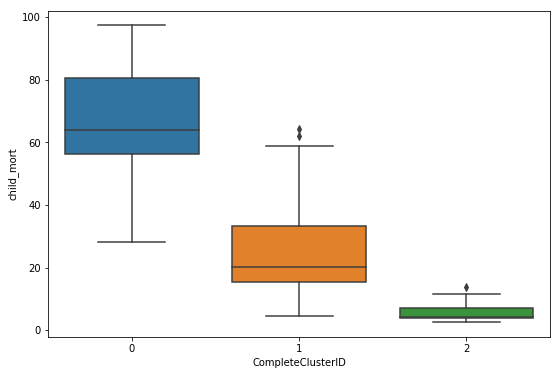

In [122]:
# Child Mortality Rate

plt.figure(figsize=(9,6))
sns.boxplot(x = 'CompleteClusterID', y = 'child_mort', data = hc_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `0` clearly includes countries that have a significantly higher `Child Mortality Rate` compared to the countries in the remaining two clusters.* </font>

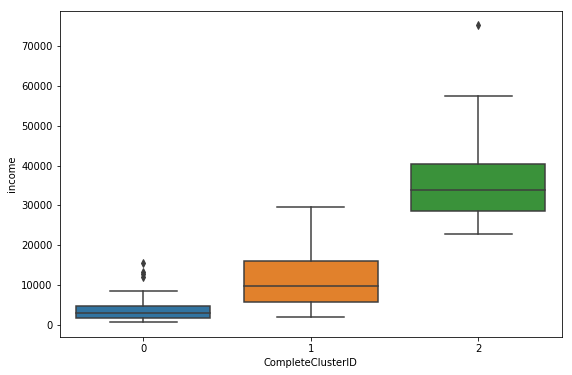

In [123]:
# Net Income per Person

plt.figure(figsize=(9,6))
sns.boxplot(x = 'CompleteClusterID', y = 'income', data = hc_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `0` clearly includes countries that have a significantly lower `Net Income per Person` compared to the countries in the remaining two clusters.* </font>

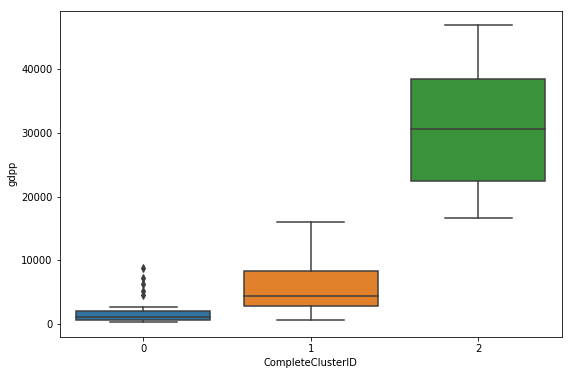

In [124]:
# Per Capita GDP

plt.figure(figsize=(9,6))
sns.boxplot(x = 'CompleteClusterID', y = 'gdpp', data = hc_cluster_df)
plt.show()

<font color = purple> *Cluster (ID) `0` clearly includes countries that have a significantly lower `Per Capita GDP` compared to the countries in the remaining two clusters.* </font>

In [99]:
# Profiling the cluster by taking the mean of various attributes

child_mort = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).child_mort.mean())
exports = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).exports.mean())
health = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).health.mean())
imports = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).imports.mean())
income = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).income.mean())
inflation = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).inflation.mean())
life_expec = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).life_expec.mean())
total_fer = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).total_fer.mean())
gdpp = pd.DataFrame(hc_cluster_df.groupby(['CompleteClusterID']).gdpp.mean())

In [100]:
# Combining the results with the Cluster ID columns

hc_final_df = pd.concat([child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp], axis=1)
hc_final_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
CompleteClusterID,,,,,,,,,
0,68.478261,884.774513,135.873852,838.634174,4650.869565,10.711304,62.169565,4.507391,2152.739130
1,24.844444,2461.066326,366.229498,2600.079382,11041.904762,6.451444,72.452381,2.410952,5804.952381
2,5.738095,14300.409524,2562.558095,12960.300000,36833.333333,3.138190,79.147619,1.803810,30957.142857


## Identifying Countries in Direst Need of Aid

In [101]:
# List of countries in dire need of aid obtained via Hierarchical clustering with Complete Linkage

hc_cluster_df[hc_cluster_df['CompleteClusterID']==0]['country'].to_frame()

,country
0,Afghanistan
13,Botswana
21,Comoros
22,"Congo, Rep."
30,Eritrea
34,Gabon
35,Gambia
38,Ghana
47,Iraq
53,Kenya


## Assigning Outliers removed earlier to clusters created via Hierarchical clustering using Complete Linkage 

In [102]:
# Reviewing the 'hc_final_df' dataframe

hc_final_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
CompleteClusterID,,,,,,,,,
0,68.478261,884.774513,135.873852,838.634174,4650.869565,10.711304,62.169565,4.507391,2152.739130
1,24.844444,2461.066326,366.229498,2600.079382,11041.904762,6.451444,72.452381,2.410952,5804.952381
2,5.738095,14300.409524,2562.558095,12960.300000,36833.333333,3.138190,79.147619,1.803810,30957.142857


In [103]:
# Creating a new dataframe by combining the original dataframe with the dataframe derived via Hierarchical clustering
# using Complete Linkage

hc_outlier_df = pd.merge(country_df, hc_cluster_df[['country', 'CompleteClusterID']], how='outer', on='country')
hc_outlier_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,CompleteClusterID
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,NaN
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,1.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,NaN
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,1.0


In [104]:
# Identifying and isolating the outlier records

hc_outlier_df = hc_outlier_df[hc_outlier_df['CompleteClusterID'].isnull()]
hc_outlier_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,CompleteClusterID
1,Albania,16.6,1145.20,267.895,1987.74,9930.0,4.49,76.3,1.65,4090.0,NaN
3,Angola,119.0,2199.19,100.605,1514.37,5900.0,22.40,60.1,6.16,3530.0,NaN
5,Argentina,14.5,1946.70,834.300,1648.00,18700.0,20.90,75.8,2.37,10300.0,NaN
7,Australia,4.8,10276.20,4530.870,10847.10,41400.0,1.16,82.0,1.93,51900.0,NaN
14,Belarus,5.5,3099.42,338.283,3889.35,16200.0,15.10,70.4,1.49,6030.0,NaN


In [105]:
# Since I chose 'CompleteClusterID' 0 for hierarchical (complete linkage) clustering to derive my list of countries 
# in need of aid, I will use the mean values for three variables in that cluster to assign the same cluster ID to the 
# appropriate outlier countries that might have received aid as well had the outliers not been removed.
# The cuttof values used are based on the mean values for the variables as seen in the dataframe: hc_final_df.

hc_outlier_df.loc[((hc_outlier_df['child_mort'] > 68) & 
                   (hc_outlier_df['income'] < 4650) & 
                   (hc_outlier_df['gdpp'] < 2152)), ['CompleteClusterID']]=0

In [108]:
# List of outlier countries that might have received aid as well had the outliers not been removed

hc_outlier_df[hc_outlier_df['CompleteClusterID']==0]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,CompleteClusterID
17,Benin,111.0,180.4040,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,0.0
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0.0
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.300,57.7,6.26,231.0,0.0
28,Cameroon,108.0,290.8200,67.2030,353.700,2660.0,1.910,57.3,5.11,1310.0,0.0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.010,47.5,5.21,446.0,0.0
32,Chad,150.0,330.0960,40.6341,390.195,1930.0,6.390,56.5,6.59,897.0,0.0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.800,57.5,6.54,334.0,0.0
40,Cote d'Ivoire,111.0,617.3200,64.6600,528.260,2690.0,5.390,56.3,5.27,1220.0,0.0
63,Guinea,109.0,196.3440,31.9464,279.936,1190.0,16.100,58.0,5.34,648.0,0.0
64,Guinea-Bissau,114.0,81.5030,46.4950,192.544,1390.0,2.970,55.6,5.05,547.0,0.0


## `Final list of countries`

In [109]:
# I chose the results obtained from Hierarchical clustering using Complete Linkage to arrive at my final list of countries

hc_cluster_df[hc_cluster_df['CompleteClusterID']==0]['country'].to_frame()

,country
0,Afghanistan
13,Botswana
21,Comoros
22,"Congo, Rep."
30,Eritrea
34,Gabon
35,Gambia
38,Ghana
47,Iraq
53,Kenya


# End